Sahana.D 2/6/2025 Predictive Modeling for Agriculture : Datacamp Project



# Sowing Success: How Machine Learning Helps Farmers Select the Best Crops

![Farmer in a field](farmer_in_a_field.jpg)

Measuring essential soil metrics such as nitrogen, phosphorous, potassium levels, and pH value is an important aspect of assessing soil condition. However, it can be an expensive and time-consuming process, which can cause farmers to prioritize which metrics to measure based on their budget constraints.

Farmers have various options when it comes to deciding which crop to plant each season. Their primary objective is to maximize the yield of their crops, taking into account different factors. One crucial factor that affects crop growth is the condition of the soil in the field, which can be assessed by measuring basic elements such as nitrogen and potassium levels. Each crop has an ideal soil condition that ensures optimal growth and maximum yield.

A farmer reached out to you as a machine learning expert for assistance in selecting the best crop for his field. They've provided you with a dataset called `soil_measures.csv`, which contains:

- `"N"`: Nitrogen content ratio in the soil
- `"P"`: Phosphorous content ratio in the soil
- `"K"`: Potassium content ratio in the soil
- `"pH"` value of the soil
- `"crop"`: categorical values that contain various crops (target variable).

Each row in this dataset represents various measures of the soil in a particular field. Based on these measurements, the crop specified in the `"crop"` column is the optimal choice for that field.  

In this project, you will build multi-class classification models to predict the type of `"crop"` and identify the single most importance feature for predictive performance.

Requirement:
Identify the single feature that has the strongest predictive performance for classifying crop types.

Find the feature in the dataset that produces the best score for predicting "crop".
From this information, create a variable called best_predictive_feature, which:
Should be a dictionary containing the best predictive feature name as a key and the evaluation score (for the metric you chose) as the value.

In [37]:
# All required libraries are imported here for you.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics

# Load the dataset
crops = pd.read_csv("soil_measures.csv")

# Write your code here

crops.shape

(2200, 5)

Observation:The Dataset has 2200 rows and 5 columns

In [38]:
crops.head()

,N,P,K,ph,crop
0,90,42,43,6.502985,rice
1,85,58,41,7.038096,rice
2,60,55,44,7.840207,rice
3,74,35,40,6.980401,rice
4,78,42,42,7.628473,rice


In [39]:
crops.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2200 entries, 0 to 2199
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   N       2200 non-null   int64  
 1   P       2200 non-null   int64  
 2   K       2200 non-null   int64  
 3   ph      2200 non-null   float64
 4   crop    2200 non-null   object 
dtypes: float64(1), int64(3), object(1)
memory usage: 86.1+ KB


Observation: 3 columns are integers ,1 column is a float and another one is an object

In [40]:
crops.isnull().sum() #check the missing values

N       0
P       0
K       0
ph      0
crop    0
dtype: int64

observation: No missing values

In [41]:
crops.nunique() #check unique values

N        137
P        117
K         73
ph      2200
crop      22
dtype: int64

In [42]:
#statistics summary
crops.describe().T 

,count,mean,std,min,25%,50%,75%,max
N,2200.0,50.551818,36.917334,0.000000,21.000000,37.000000,84.250000,140.000000
P,2200.0,53.362727,32.985883,5.000000,28.000000,51.000000,68.000000,145.000000
K,2200.0,48.149091,50.647931,5.000000,20.000000,32.000000,49.000000,205.000000
ph,2200.0,6.469480,0.773938,3.504752,5.971693,6.425045,6.923643,9.935091


Observation: Nitrogen(N) has outliers(140 is quite high when compare with median 37). P(Phosphorous) has 145 and Pottasium(K) has 205. The pH values are in typical range. 


Correlation Analysis:
  Variables  Correlation       P-value
0    N vs P    -0.231460  3.823471e-28
1   N vs ph     0.096683  5.548665e-06
2   P vs ph    -0.138019  7.972631e-11
3    K vs N    -0.140512  3.599057e-11
4    K vs P     0.736232  0.000000e+00
5   K vs ph    -0.169503  1.205751e-15


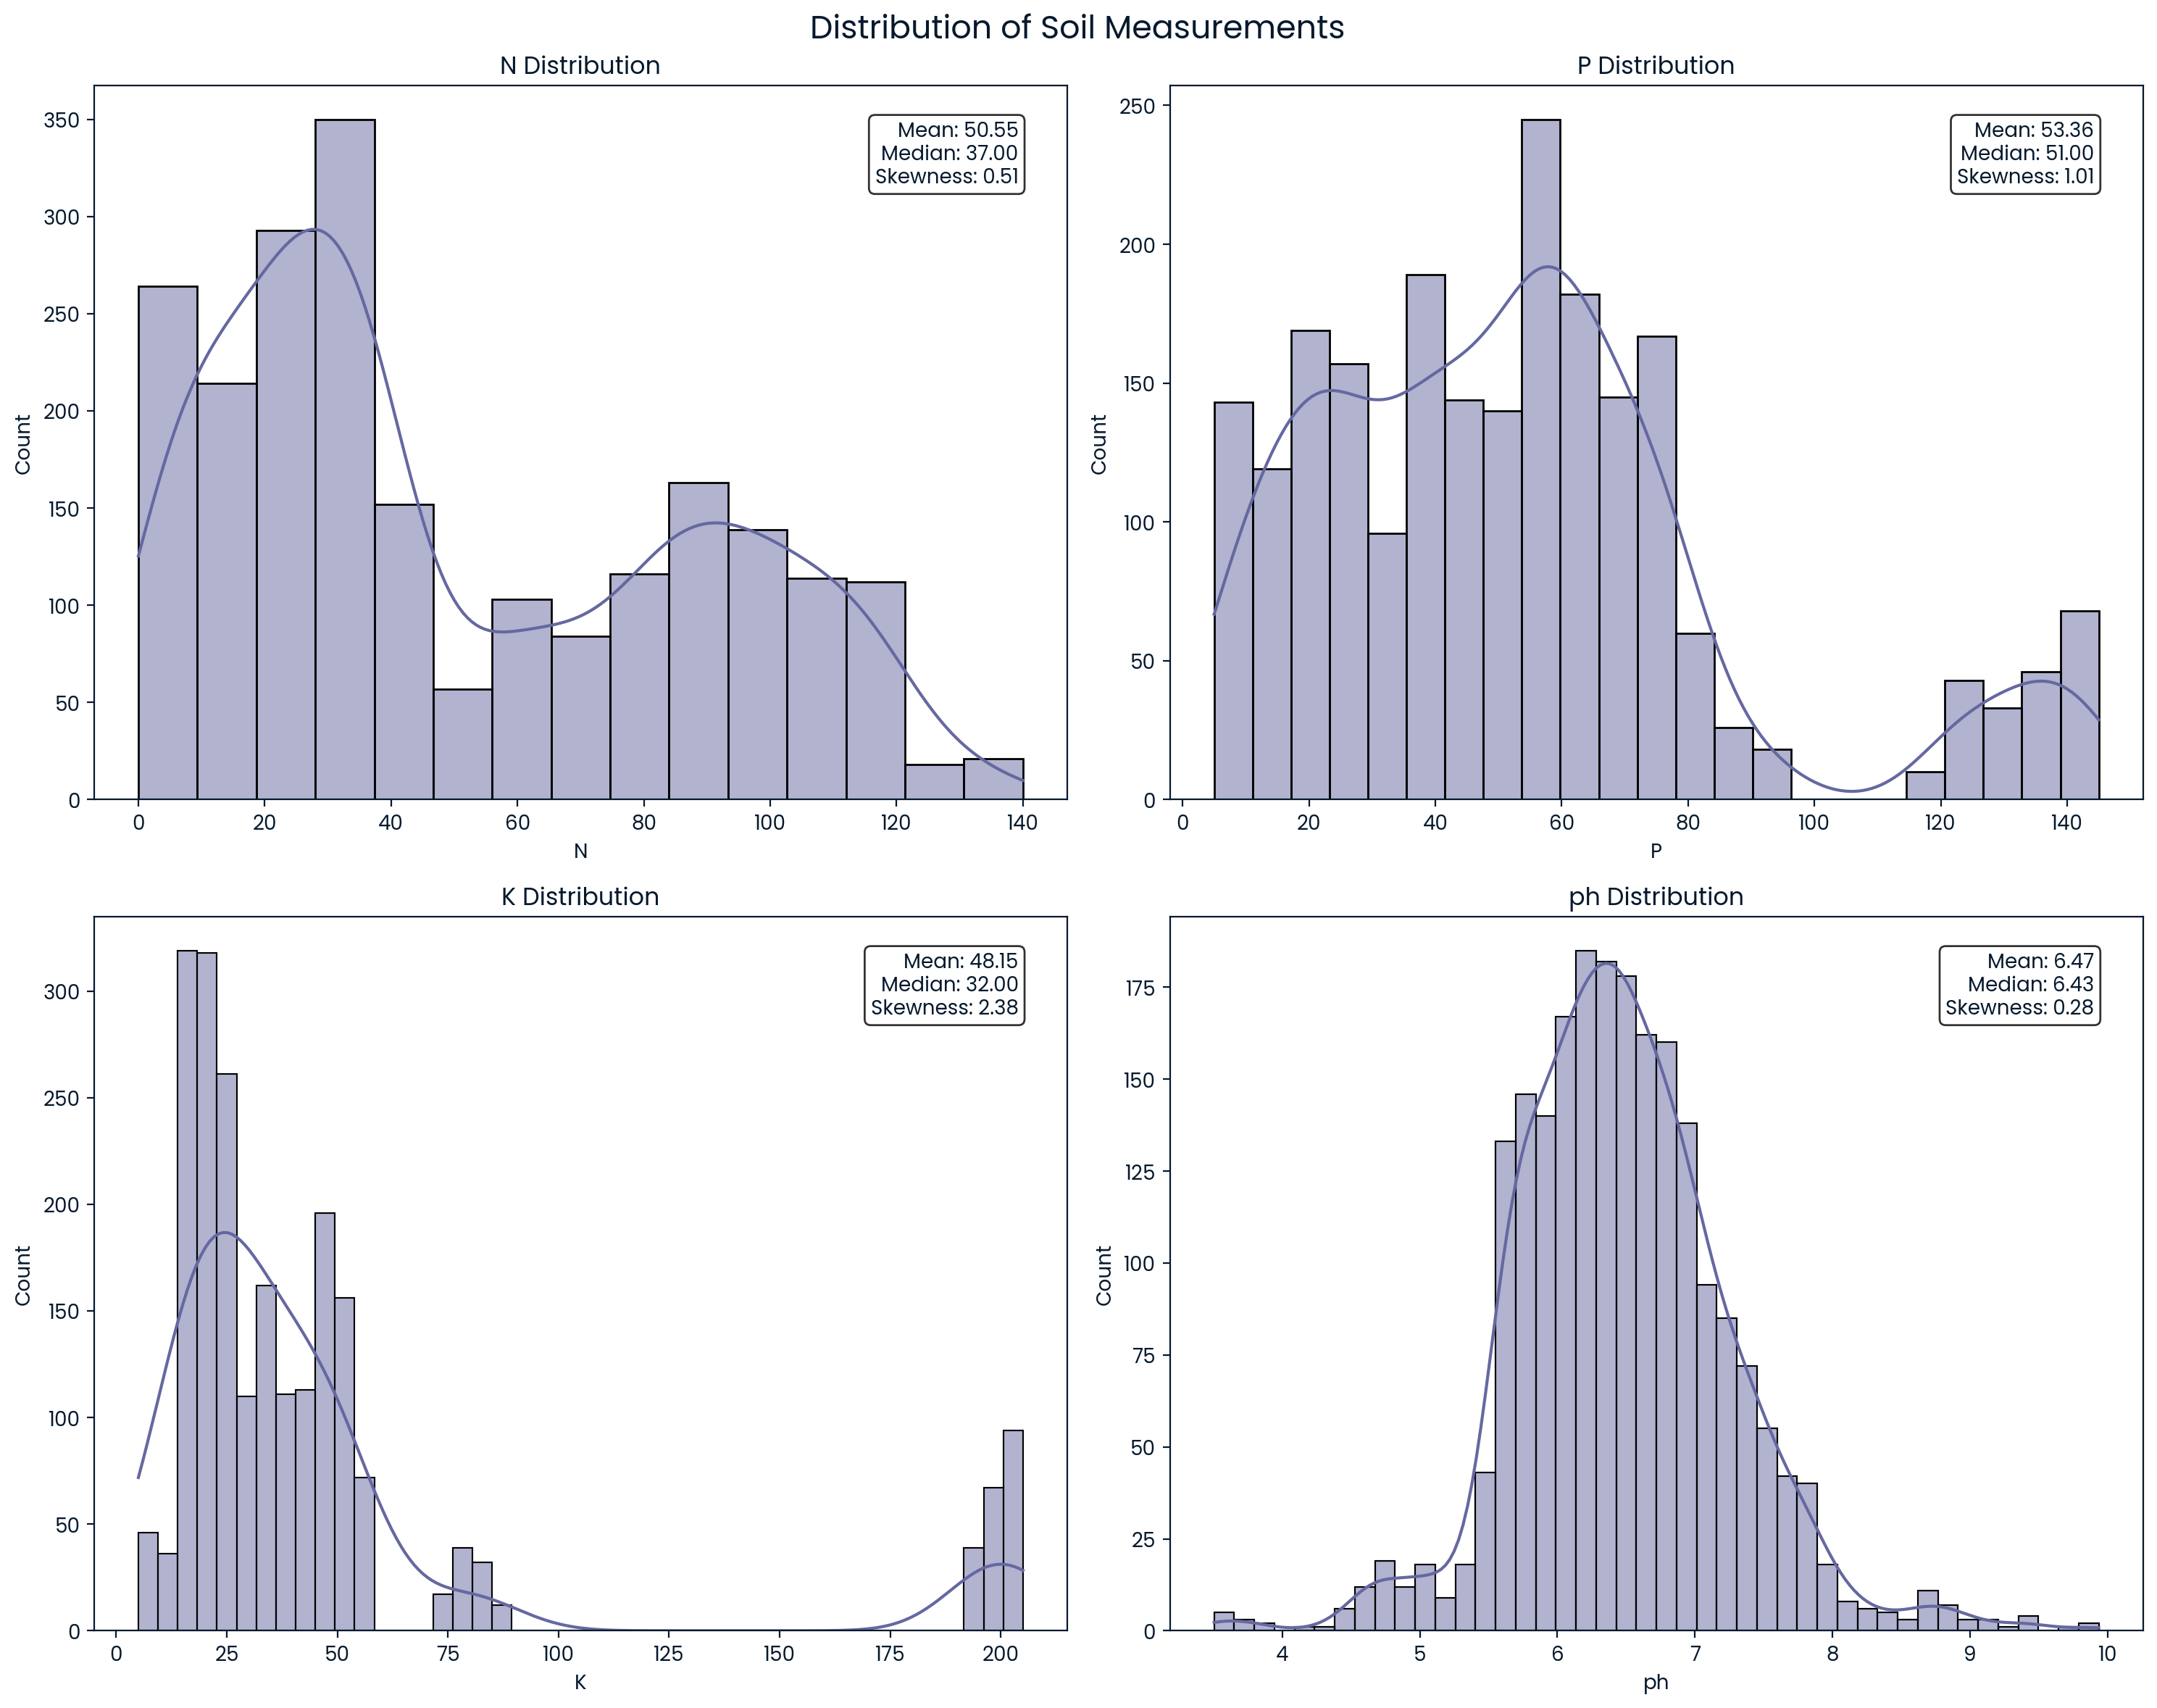

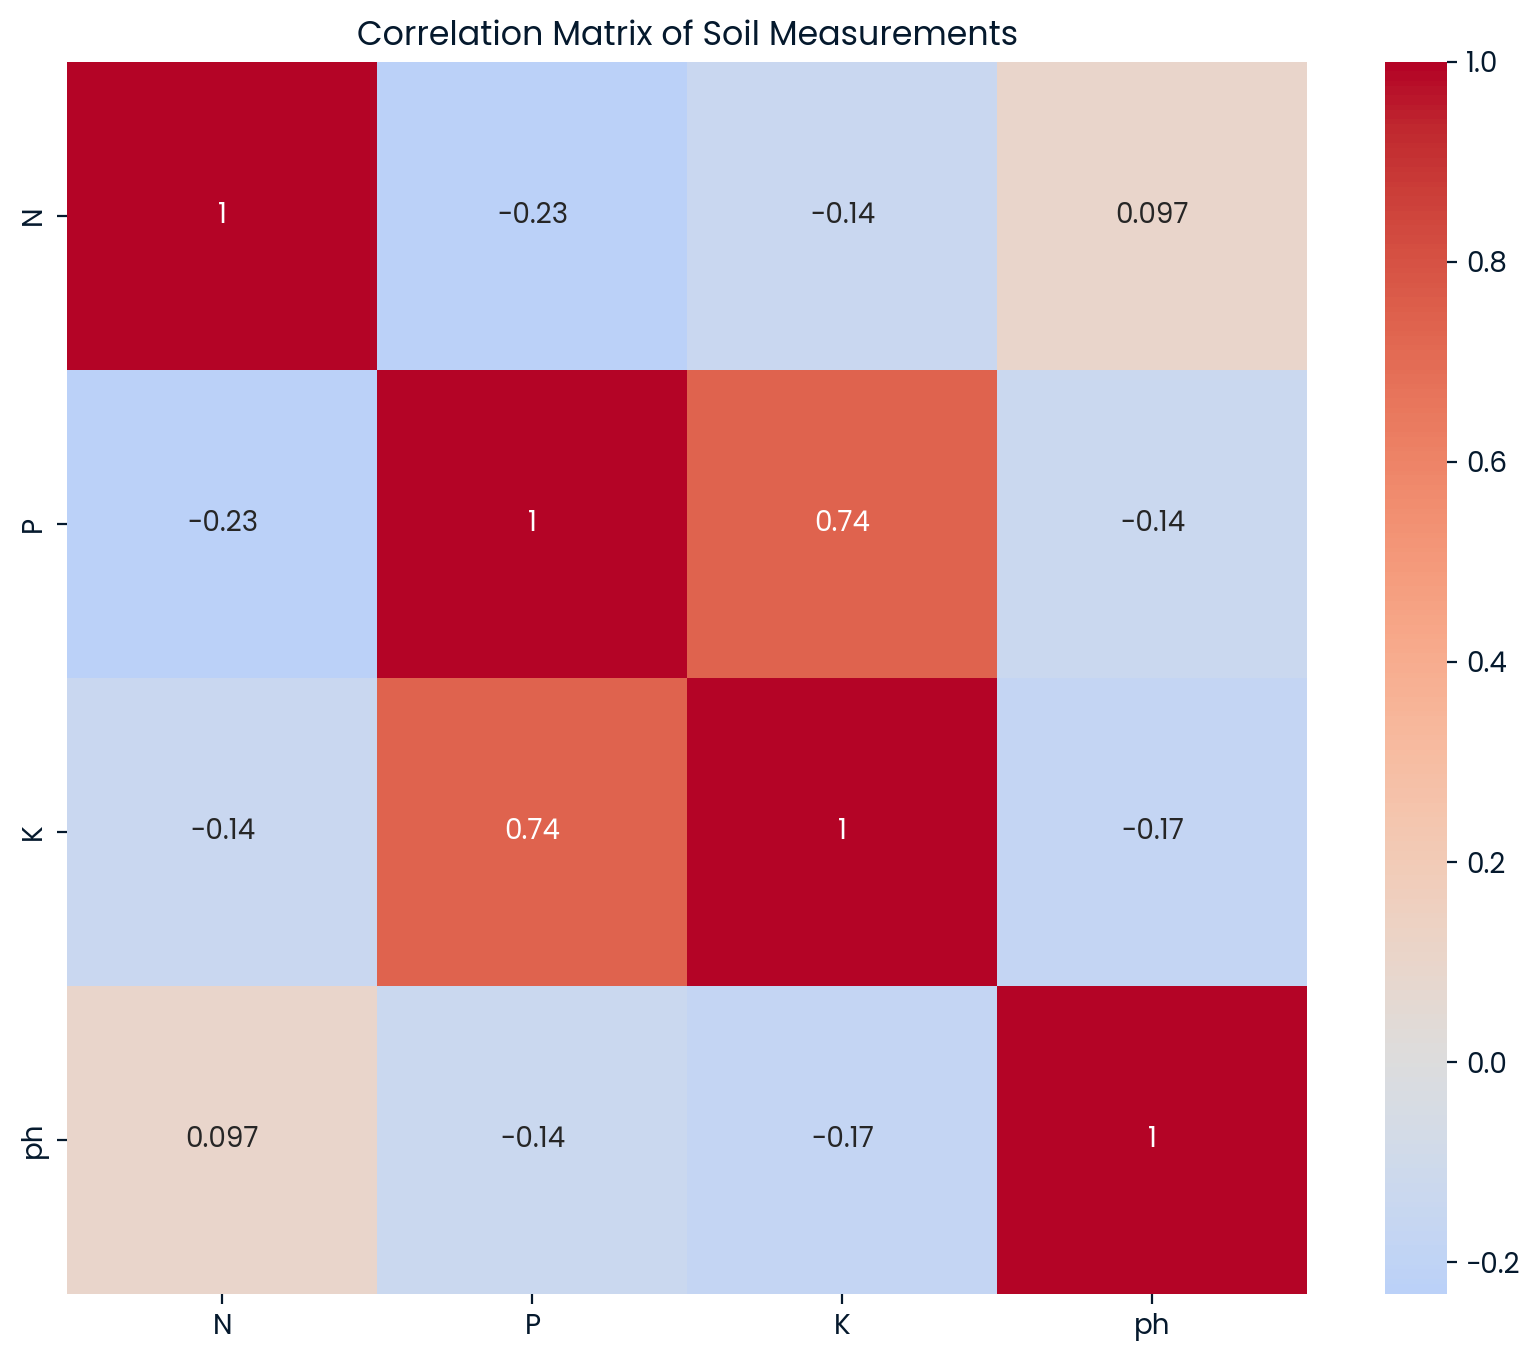

<Figure size 1200x1200 with 0 Axes>

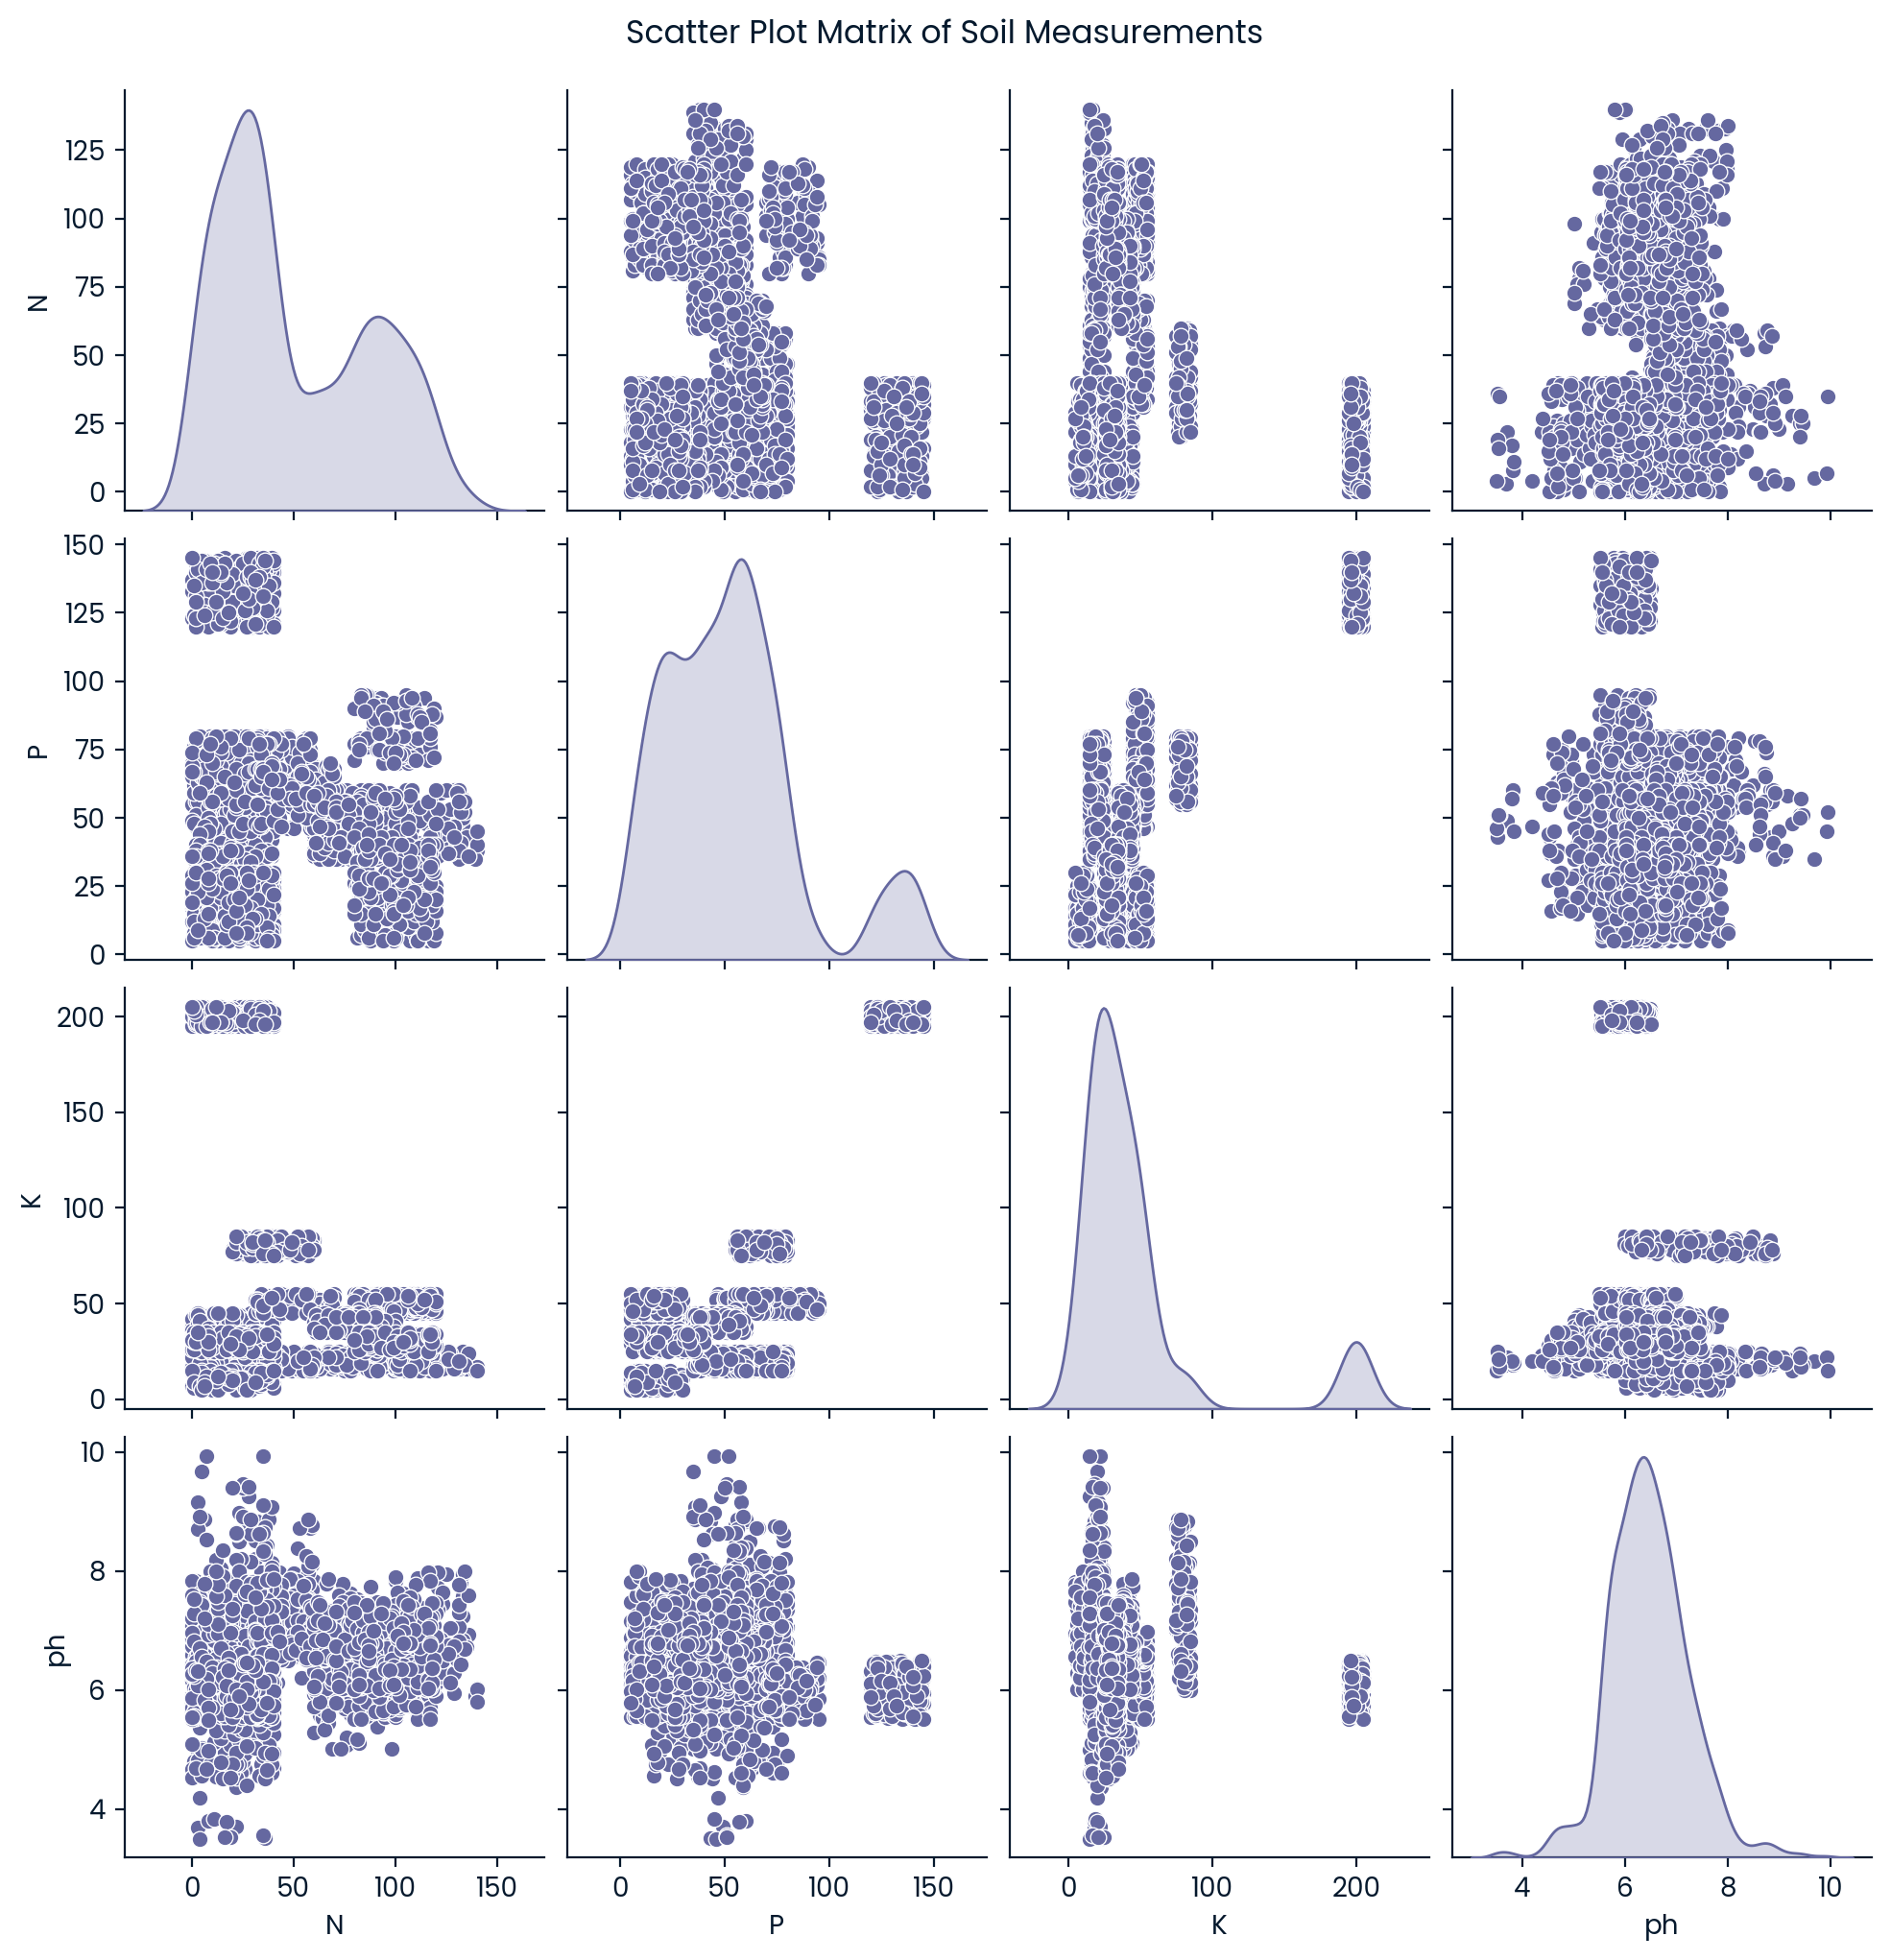

In [43]:
#Exploratory Data Analysis

# Univariate Analysis
def plot_univariate_analysis(data):
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle('Distribution of Soil Measurements', fontsize=16)
    
    # Histograms and KDE plots
    for idx, column in enumerate(['N', 'P', 'K', 'ph']):
        row = idx // 2
        col = idx % 2
        
        sns.histplot(data=data, x=column, kde=True, ax=axes[row, col])
        axes[row, col].set_title(f'{column} Distribution')
        
        # Add summary statistics
        mean_val = data[column].mean()
        median_val = data[column].median()
        skew_val = data[column].skew()
        
        stats_text = f'Mean: {mean_val:.2f}\nMedian: {median_val:.2f}\nSkewness: {skew_val:.2f}'
        axes[row, col].text(0.95, 0.95, stats_text,
                          transform=axes[row, col].transAxes,
                          verticalalignment='top',
                          horizontalalignment='right',
                          bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    plt.tight_layout()
    
# Bivariate Analysis
def plot_bivariate_analysis(data):
    # Correlation matrix
    plt.figure(figsize=(10, 8))
    corr_matrix = data[['N', 'P', 'K', 'ph']].corr()
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0)
    plt.title('Correlation Matrix of Soil Measurements')
    
    # Scatter plot matrix
    plt.figure(figsize=(12, 12))
    sns.pairplot(data[['N', 'P', 'K', 'ph']], diag_kind='kde')
    plt.suptitle('Scatter Plot Matrix of Soil Measurements', y=1.02)

# Correlation analysis
def print_correlation_analysis(data):
    correlations = []
    variables = ['N', 'P', 'K', 'ph']
    
    for var1 in variables:
        for var2 in variables:
            if var1 < var2:  # To avoid duplicate combinations
                correlation = stats.pearsonr(data[var1], data[var2])
                correlations.append({
                    'Variables': f'{var1} vs {var2}',
                    'Correlation': correlation[0],
                    'P-value': correlation[1]
                })
    
    return pd.DataFrame(correlations)

# Run the analysis
plot_univariate_analysis(crops)
plot_bivariate_analysis(crops)
correlation_results = print_correlation_analysis(crops)
print("\nCorrelation Analysis:")
print(correlation_results)

Observation: P and K show the strongest positive correlation (0.74).This means if phosphorus levels increase, potassium levels tend to increase as well.Most correlations in this dataset are relatively weak, except for the P-K relationshp.

In [44]:
# Split into feature and target sets
X = crops.drop(columns="crop")
y = crops["crop"]

In [45]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42
)

In [46]:
# Create a dictionary to store the model performance for each feature
feature_performance = {}

# Train a logistic regression model for each feature
for feature in ["N", "P", "K", "ph"]:
    log_reg = LogisticRegression(multi_class="multinomial")
    log_reg.fit(X_train[[feature]], y_train)
    y_pred = log_reg.predict(X_test[[feature]])
    
    # Calculate F1 score, the harmonic mean of precision and recall
    # Could also use balanced_accuracy_score
    f1 = metrics.f1_score(y_test, y_pred, average="weighted")
    
    # Add feature-f1 score pairs to the dictionary
    feature_performance[feature] = f1
    print(f"F1-score for {feature}: {f1}")

# K produced the best F1 score
# Store in best_predictive_feature dictionary
best_predictive_feature = {"K": feature_performance["K"]}
best_predictive_feature

F1-score for N: 0.09149868209906838
F1-score for P: 0.14761942909728204
F1-score for K: 0.23896974566001802
F1-score for ph: 0.04532731061152114


{'K': 0.23896974566001802}

Requirement:
Identify the single feature that has the strongest predictive performance for classifying crop types.
Find the feature in the dataset that produces the best score for predicting "crop".
From this information, create a variable called best_predictive_feature, which:
Should be a dictionary containing the best predictive feature name as a key and the evaluation score (for the metric you chose) as the value.

Solution:

F1-score for N: 0.09149868209906838
F1-score for P: 0.14761942909728204
F1-score for K: 0.23896974566001802
F1-score for ph: 0.04532731061152114
{'K': 0.23896974566001802}

The best predictive feature for classifying crop types is Potassium (K) with an F1-score of 0.239, which is significantly higher than the other features:
K (Potassium): 0.239
P (Phosphorus): 0.148
N (Nitrogen): 0.091
pH: 0.045
The best_predictive_feature dictionary is correctly formatted as:
{'K': 0.23896974566001802}
